In [17]:
from astropy.time import Time
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
import numpy as np

dates = Time('2021-09-01 00:00', scale='tdb') + np.arange(780 * 2)
earth = Ephem.from_body(Earth, dates)
mars = Ephem.from_body(Mars, dates)

In [18]:
np.linalg.norm(Orbit.from_ephem(Sun, earth, dates[0]).v.to('m/s'))

<Quantity 29498.61882431 m / s>

In [3]:
foo = 0.5

f"{foo}"

'0.5'

In [58]:
np.ceil((dates[-1] - dates[0]).value)

1559.0

In [49]:
from poliastro.maneuver import Maneuver
import scipy.optimize as optim

def delta_v(x):
    t0, tof = x
    epoch = Time(t0, format='jd')

    orbit1 = Orbit.from_ephem(Sun, earth, epoch)
    orbit2 = Orbit.from_ephem(Sun, mars, epoch + tof)
    dv = Maneuver.lambert(orbit1, orbit2).get_total_cost()  # km / s
    return np.asarray(dv)   # Unit erasure

# Initialize t0 at the point of closest approach
earth_pos, _ = earth.rv()
mars_pos, _ = mars.rv()
offset = np.argmin(np.linalg.norm(earth_pos[:780] - mars_pos[:780], axis=1))
t0_init, tof_init = dates[offset].jd, 780.0 - offset

optim.minimize(
    fun=delta_v,
    x0=np.array([t0_init, tof_init]),
    bounds=[(dates[0].jd, dates[-1].jd), (1.0, 780.0)]
)

      fun: array(6.85537802)
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00016966, -0.0003844 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 111
      nit: 11
     njev: 37
   status: 0
  success: True
        x: array([2.45982246e+06, 3.48590880e+02])

In [51]:
Time(2.45982246e+06, format='jd').to_datetime().isoformat()

'2022-08-30T23:02:23.999997'

In [46]:
dates[0].jd

2459458.5

In [1]:
import pykep as pk
import numpy as np

def planetary_distance(planet1, planet2, epoch):
    r1, _ = np.array(planet1.eph(epoch))
    r2, _ = np.array(planet2.eph(epoch))
    return np.linalg.norm(r1 - r2)

In [10]:
import pykep as pk
import numpy as np

def planetary_angle(planet1, planet2, epoch):
    r1, _ = np.array(planet1.eph(epoch))
    r2, _ = np.array(planet2.eph(epoch))

    r1_hat, r2_hat = r1 / np.linalg.norm(r1), r2 /np.linalg.norm(r2)
    return np.arccos(r1_hat.dot(r2_hat))

In [13]:
import pykep as pk
import numpy as np
import math

def hohmann_dv(planet1, planet2, epoch, tof = 254.0):
    r1, v1 = planet1.eph(epoch)
    r2, v2 = planet2.eph(epoch)
    v1, v2 = np.array(v1), np.array(v2)

    cw = (pk.ic2par(r1, v1, pk.MU_SUN)[2] > math.pi / 2)
    lambert = pk.lambert_problem(r1, r2, tof * pk.DAY2SEC, pk.MU_SUN, cw)
    transfer_v1, transfer_v2 = np.array(lambert.get_v1()[0]), np.array(lambert.get_v2()[0])
    
    return np.linalg.norm(transfer_v1 - v1) + np.linalg.norm(v2 - transfer_v2)

In [8]:
import pykep as pk
from pathfinder.constants import current_epoch

earth, neptune = pk.planet.jpl_lp('earth'), pk.planet.jpl_lp('neptune')

now = current_epoch()
period1, period2 = earth.compute_period(now), neptune.compute_period(now)
opposition_period = 1 / abs(1 / period1 - 1 / period2)
opposition_period * pk.SEC2DAY

367.48766276490153

In [6]:
r1, _ = np.array(earth.eph(now))
r2, _ = np.array(mars.eph(now))

In [5]:
import numpy as np
from astropy.units import Unit

np.arccos(0.5 * Unit('1'))

<Quantity 1.04719755 rad>

In [7]:
180 - 360 * (1 - 0.5 * np.sqrt(0.5 * (np.linalg.norm(r1) / np.linalg.norm(r2) + 1) ** 3)) / 2

129.9952076197082

In [11]:
planetary_angle(earth, neptune, now)

0.5385142456233823

In [63]:
hohmann_dv(earth, mars, now)

12516.068574806875

In [4]:
import numpy as np
np.array(1.0).ravel().shape

(1,)

In [1]:
from astropy.time import Time
from astropy.units import Unit
from pathfinder.problems import ImpulsiveTransfer
from poliastro.bodies import Venus, Mercury, Saturn, Pluto, Jupiter, Neptune, Sun, Earth, Mars, Body
from poliastro.twobody import Orbit

In [3]:
objective = ImpulsiveTransfer(source=Earth, target=Mars, latest_arrival=Time('2030-12-31', scale='tdb'))
good, crap = objective.compute()

Total function evals: 172


In [7]:
1 / abs(1 / Orbit.from_sbdb('132 Aethra').period.to('yr') - 1 * Unit('1/yr'))

<Quantity 1.31111701 yr>

In [4]:
from astropy.units import Unit
from datetime import datetime
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit
import numpy as np

def _get_orbit(attractor, planet, epoch: Time) -> Orbit:
     return Orbit.from_ephem(attractor, Ephem.from_body(planet, epoch), epoch)

target = Mars
now = Time(datetime.utcnow(), scale='tdb')
orbit1, orbit2 = _get_orbit(Sun, Earth, now), _get_orbit(Sun, target, now) # Orbit.from_sbdb('16 Psyche')
denom = np.linalg.norm(orbit1.r)
mu = Sun.k

In [14]:
from matplotlib import cm
from poliastro.maneuver import Maneuver
# from numba import vectorize
import numpy as np

days = Unit('d')
rad = Unit('rad')
num_hyperbolic = 0

@np.vectorize
def dv_anomaly(anomaly1: float, anomaly2: float):
    launch = orbit1.propagate_to_anomaly(anomaly1 * rad)
    arrival = orbit2.propagate_to_anomaly(anomaly2 * rad)
    if launch.epoch >= arrival.epoch:
        classical = arrival.classical()
        arrival = Orbit.from_classical(arrival.attractor, *classical[:6], arrival.epoch + arrival.period, arrival.plane)

    dv = Maneuver.lambert(launch, arrival).get_total_cost()
    return np.asarray(dv)

@np.vectorize
def lambert_dv(t_prime: float, tof: float):
    t = t_prime * days
    
    launch = orbit1.propagate(t)
    arrival = orbit2.propagate(t + tof * days)

    dv = Maneuver.lambert(launch, arrival).get_total_cost()
    return np.asarray(dv)

X = np.arange(0.0, 2 * np.pi, np.pi / 40)
Y = np.arange(0.0, 2 * np.pi, np.pi / 40)
X, Y = np.meshgrid(X, Y)
Z = dv_anomaly(X, Y)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches((8, 8))
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel('Launch date (days from now)')
ax.set_ylabel('Time of flight (days)')
ax.set_zlabel('Delta v (km/s)')

In [16]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=X + Y, y=Y, z=Z)])
fig.update_layout(
    height=700,
    width=700,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=50,
        pad=4
    ),
    title=f'Delta-v to 16 Psyche vs. Launch Date & ToF',
    scene=dict(
        zaxis=dict(range=[0.0, 100.0]),
        xaxis_title='Arrival date (days from now)',
        yaxis_title='Time of flight (days)',
        zaxis_title='Delta v (km/s)'
    )
)
fig.show()

In [44]:
np.min(Z)

18.673006728444484

In [45]:
Z.shape

(48, 200)

In [5]:
from astropy.units import Unit
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import time_range

launch = good.launch_date
arrival = launch + good.time_of_flight

source = Ephem.from_body(objective.source, time_range(launch, end=arrival))
target = Ephem.from_body(objective.target, launch)
orbit0 = Orbit.from_ephem(Sun, source, launch)

plotter = OrbitPlotter3D()
plotter.plot(orbit0, label=f'{objective.source.name} at launch')
# plotter.plot_ephem(earth, transfer.launch_date, label='Earth at launch')
plotter.plot_ephem(target, launch, label=f'{objective.target.name} at launch')
plotter.plot_body_orbit(objective.target, arrival, label=f'{objective.target.name} at arrival')

transfer_orbit, _ = orbit0.apply_maneuver(good.maneuver, intermediate=True)
plotter.plot_trajectory(transfer_orbit.sample(max_anomaly=220 * Unit('deg')), color='black', label='Transfer')

1 x 2 AU x 62.1 deg (HCRS) orbit around Sun (☉) at epoch 2022-08-09 00:01:49.163067 (TDB)

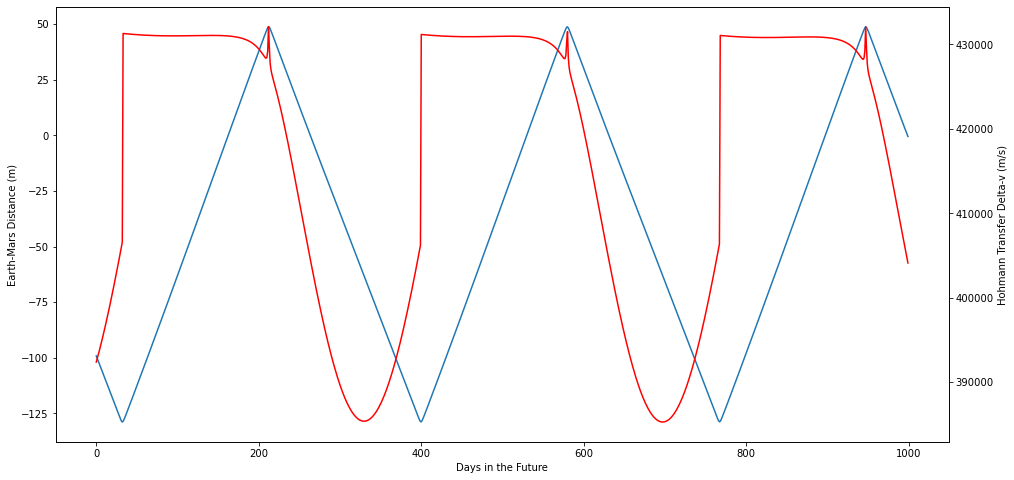

In [14]:
import matplotlib.pyplot as plt
from astropy.units import Time
from datetime import datetime
from poliastro.bodies import Earth
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit

now = Time(datetime.utcnow(), scale='tdb')
earth_ephem = Ephem.from_body(Earth, now)
mars_ephem = Ephem.from_body(Mars, now)


offset = 0
xlim = 1000

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)

epochs = [pk.epoch(now.mjd2000 + x) for x in range(offset, xlim + offset)]
dists = [planetary_angle(earth, neptune, epoch) * (360 / (2 * np.pi)) - 129.99513640353416 for epoch in epochs]

ax1.set_xlabel("Days in the Future")
ax1.set_ylabel("Earth-Mars Distance (m)")
ax1.plot(list(range(xlim)), dists)

ax2 = ax1.twinx()

dvs = [hohmann_dv(earth, neptune, epoch, tof=250.0) for epoch in epochs]
ax2.set_ylabel("Hohmann Transfer Delta-v (m/s)")
ax2.plot(list(range(xlim)), dvs, color='red')

In [27]:
min(dvs)

7284.235599634529

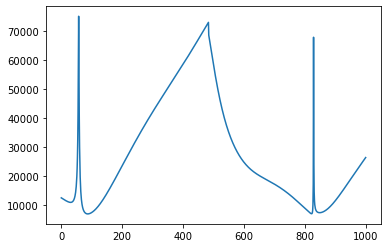

In [20]:
import matplotlib.pyplot as plt

dvs = [hohmann_dv(earth, mars, epoch) for epoch in epochs]
plt.plot(list(range(1000)), dvs)

In [12]:
lambert = pk.lambert_problem(r_0, r_f, 300 * pk.DAY2SEC, pk.MU_SUN)
lambert.get_v1()

((24296.421622878155, -17763.53382959392, -548.8434710245266),)

In [17]:
udp.pretty(pop.champion_x)

Total DV (m/s):  5870.74938557078
Dvs (m/s):  [3346.877824575315, 2523.8715609954643]
Tofs (days):  [342.0794560236768]


In [1]:
from pathfinder import get_asteroid_info, get_mars_crossers

info = get_asteroid_info()

Loading cached asteroid info from 'jpl-asteriod-info.csv'


In [2]:
info.dtypes

full_name          string
e                 float64
a                 float64
i                 float64
om                float64
w                 float64
ma                float64
sigma_e           float64
sigma_a           float64
sigma_i           float64
sigma_om          float64
sigma_w           float64
sigma_ma          float64
diameter          float64
diameter_sigma    float64
epoch             float64
spec_T             string
spec_B             string
dtype: object

In [6]:
info.e.astype('float')

spkid
2000001    0.0784
2000002    0.2298
2000003    0.2570
2000004    0.0884
2000005    0.1906
            ...  
3839175    0.2448
3839314    0.2971
3839472    0.2430
3839444    0.1577
3840108    0.2497
Name: e, Length: 139900, dtype: float64

In [15]:
MARS_A = 1.523679
MARS_E = 0.0934

mars_crossing_As = MARS_A * (1 - MARS_E) / (1 - info.e.astype('float'))
mars_crossing_energies = 1 / (2 * info.a.astype('float')) - 1 / (2 * mars_crossing_As)

In [22]:
info.loc['3400292']

full_name                (2008 BF2)
e                            0.4698
a                             2.595
i                             22.53
om                           332.38
w                             89.10
ma                           112.62
sigma_e                     7.8e-08
sigma_a                     4.6e-08
sigma_i                     9.7e-06
sigma_om                    1.2e-05
sigma_w                     2.0e-05
sigma_ma                    2.1e-05
diameter                      1.187
diameter_sigma                 0.24
epoch                     2459396.5
spec_T                         <NA>
spec_B                         <NA>
Name: 3400292, dtype: string

In [20]:
mars_crossing_energies[mars_crossing_energies > 0.0].sort_values()

spkid
2402138    0.000433
3400292    0.000767
3674739    0.000945
3529586    0.001255
2301964    0.001705
             ...   
2138127    0.586552
3402610    0.605067
3542519    0.615719
2325102    0.663383
2066391    0.665544
Length: 1298, dtype: float64

In [13]:
info.loc['3536477']

full_name                (2010 MN107)
e                              0.0001
a                               2.678
i                               26.16
om                             311.35
w                              105.80
ma                             292.44
sigma_e                       3.1e-01
sigma_a                       3.2e+00
sigma_i                       4.9e+00
sigma_om                      1.3e+01
sigma_w                       9.5e+05
sigma_ma                      9.5e+05
diameter                        2.613
diameter_sigma                   0.80
epoch                       2455378.5
spec_T                           <NA>
spec_B                           <NA>
Name: 3536477, dtype: string

In [11]:
deltas.sort_values()

spkid
3536477     1.381506
2304710     1.381782
2248120     1.382612
2006352     1.382750
2245246     1.382750
             ...    
3523334    36.836464
2336756    40.868857
2394130    43.852933
3517549    44.560238
3547316    85.269591
Name: e, Length: 139900, dtype: float64

<Axes3DSubplot:>

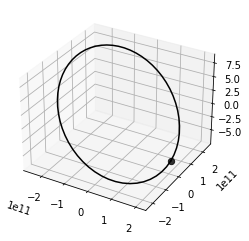

In [1]:
import pykep as pk

pk.orbit_plots.plot_planet(pk.planet.jpl_lp('mars'))

In [2]:
from pathfinder import search_asteroids_by_name

search_asteroids_by_name('132 Aethra')

full_name       e      a      i      om       w     ma  \
spkid                                                                           
2000132     132 Aethra (A873 LA)  0.3893  2.609  24.98  258.38  255.25  98.63   

         sigma_e  sigma_a  sigma_i sigma_om  sigma_w sigma_ma diameter  \
spkid                                                                    
2000132  1.1e-08  4.2e-09  4.7e-07  1.5e-06  1.8e-06  1.4e-06    42.87   

        diameter_sigma extent spec_T spec_B  
spkid                                        
2000132           1.60   <NA>      M     Xe

In [3]:
from pathfinder import get_close_approaches

get_close_approaches(2000132, 'Mars')

{'object': {'shortname': '132 Aethra',
  'neo': False,
  'orbit_class': {'name': 'Mars-crossing Asteroid', 'code': 'MCA'},
  'pha': False,
  'spkid': '2000132',
  'kind': 'an',
  'orbit_id': '61',
  'fullname': '132 Aethra (A873 LA)',
  'des': '132',
  'prefix': None},
 'signature': {'source': 'NASA/JPL Small-Body Database (SBDB) API',
  'version': '1.2'},
 'ca_data': [],
 'orbit': {'source': 'JPL',
  'cov_epoch': '2457369.5',
  'moid_jup': '2.19',
  't_jup': '3.177',
  'condition_code': '0',
  'not_valid_before': None,
  'rms': '0.37',
  'model_pars': [],
  'orbit_id': '61',
  'producer': 'Otto Matic',
  'first_obs': '1873-06-14',
  'soln_date': '2021-07-08 10:34:45',
  'two_body': None,
  'epoch': '2459396.5',
  'elements': [{'value': '0.389',
    'sigma': '1.1e-08',
    'name': 'e',
    'title': 'eccentricity',
    'label': 'e',
    'units': None},
   {'value': '2.61',
    'sigma': '4.2e-09',
    'name': 'a',
    'title': 'semi-major axis',
    'label': 'a',
    'units': 'au'},
   {

In [6]:
bf_1992 = [vecs['x'].to('m'), vecs['y'].to('m'), vecs['z'].to('m'), vecs['vx'].to('m/s'), vecs['vy'].to('m/s'), vecs['vz'].to('m/s')]

In [7]:
bf_1992

[<Quantity [-1.44706091e+11] m>,
 <Quantity [3.94627669e+10] m>,
 <Quantity [-9.40150197e+09] m>,
 <Quantity [-137.76618528] m / s>,
 <Quantity [-27969.60914975] m / s>,
 <Quantity [-2542.32050386] m / s>]

(array([444., 309., 156.,  51.,  24.,  10.,   4.,   1.,   0.,   1.]),
 array([4.22924808e+08, 5.05338898e+10, 1.00644855e+11, 1.50755820e+11,
        2.00866785e+11, 2.50977750e+11, 3.01088715e+11, 3.51199680e+11,
        4.01310645e+11, 4.51421610e+11, 5.01532575e+11]),
 <BarContainer object of 10 artists>)

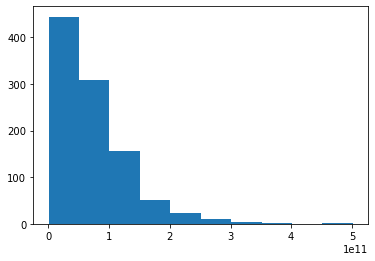

In [162]:
from astropy.units import Unit
import matplotlib.pyplot as plt

asteroid_diameters = (np.random.randn(1000) * 0.08 + 0.272) * Unit('km')
asteroid_masses = (5.32 * Unit('g/cm**3') * (np.pi / 6.0) * asteroid_diameters ** 3.0).to('kg')

plt.hist(np.asarray(asteroid_masses))

In [164]:
np.median(asteroid_masses)

<Quantity 5.73739939e+10 kg>

/Users/nora/.pyenv/versions/3.8.6/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Text(0.5, 1.0, 'Orbital Speed of 132 Aethra')

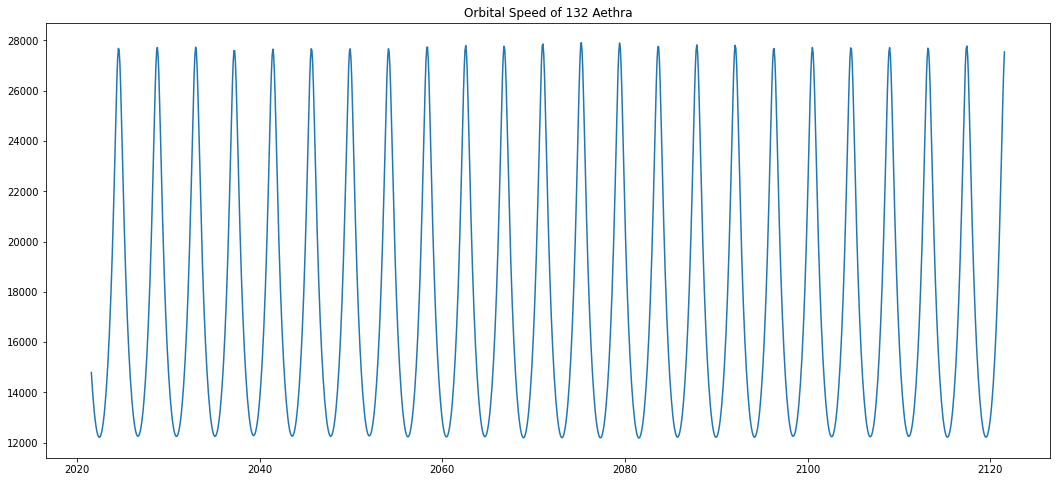

In [ ]:
velocity = np.stack([vecs['vx'], vecs['vy'], vecs['vz']]) * u.au / u.d
speed = np.linalg.norm(velocity, axis=0).to('m/s')

fig = plt.gcf()
fig.set_size_inches(18, 8)
plt.plot([x.to_datetime() for x in times], speed[:mars.shape[1]])
plt.title("Orbital Speed of 132 Aethra")

In [145]:
from astropy.units import Unit

GM_SUN = 1.32712440018e20 * Unit('meter') ** 3 / Unit('second') ** 2.0

grav_param = Unit('m**3/s**2')

# Gravitational constant value from CODATA 2018- the last 2 sig figs are uncertain
BIG_G = 6.67430e-11 * grav_param / 'kg'

In [ ]:
(np.array(1.32712440018e20) / np.array(6.67430e-11)) * np.array(6.67430e-11)

1.32712440018e+20

In [ ]:
pos = np.array([
    [0.0, 0.0, 0.0],
    [1.496e+11, 0.0, 0.0]
]) * Unit('m')
mass = np.array([1.989e30, 6.417e23]) * Unit('kg')

def compute_gravity(pos, mass) -> Quantity:
    diffs = pos - pos[..., None, :]         # [N, N, 3]
    dists = np.linalg.norm(diffs, axis=-1)  # [N, N]

    # Mask out non-existent gravitational attractions of objects to themselves, which would
    # otherwise cause a divide by zero error (since the distance is 0)
    np.fill_diagonal(dists, np.inf)
    return BIG_G * np.sum(mass[None, :, None] * diffs / dists[..., None] ** 3, axis=-2)  # [N, 3]

compute_gravity(pos, mass)

<Quantity [[ 1.91370317e-09,  0.00000000e+00,  0.00000000e+00],
           [-5.93167462e-03,  0.00000000e+00,  0.00000000e+00]] m / s2>

In [5]:
from astropy.units import Unit
from pathfinder import State
import numpy as np

system = np.stack([
    State.get_body('Sun'),
    State.get_body('Venus'),
    State.get_body('Earth'),
    State.get_body('Mars')
    # State.get_body('Jupiter')
])
system = State(system)
system.compute_gravity()

<Quantity [[-1.13233894e-08, -2.73879691e-08, -1.07050228e-08],
           [ 9.06867066e-03,  6.41819534e-03,  2.31412980e-03],
           [-3.84377872e-03,  3.93701769e-03,  1.70670256e-03],
           [ 2.07789398e-03, -4.53050424e-04, -2.63872296e-04]] m / s2>

In [14]:
import torch

SECS_PER_YEAR = 31_556_952
SECS_PER_WEEK = 604_800

result = system.evolve(torch.arange(0.0, SECS_PER_YEAR * 20, step=SECS_PER_WEEK))